In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

from skimage import data, transform, io, exposure
from skimage.color import rgb2gray
from skimage.feature import match_descriptors, plot_matches, SIFT, match_template, ORB
from skimage.transform import rescale, resize, downscale_local_mean, estimate_transform
from skimage.transform import warp, AffineTransform, ProjectiveTransform, estimate_transform
from skimage.measure import ransac

import rasterio as rio
from rasterio.crs import CRS

import cv2
from affine import Affine
import numpy as np
import os

In [10]:
img1 = cv2.cvtColor(cv2.imread(r"D:\FloodChange\BaseRaster\BaseTest.tif"), cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(cv2.imread(r"C:\Users\fhacesga\Desktop\FIRMsDigitizing\data\4802870065E.png"), cv2.COLOR_BGR2GRAY)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


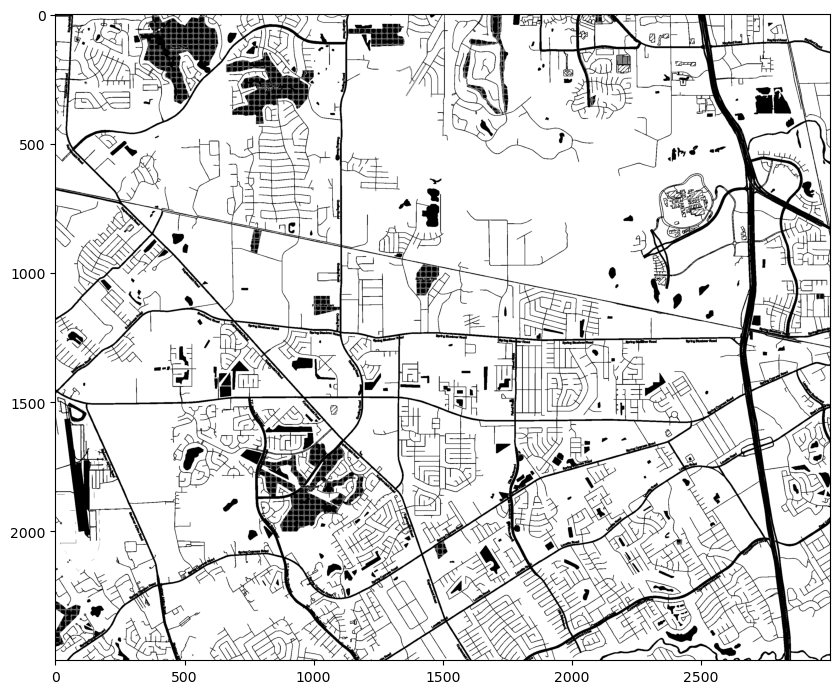

In [4]:
fig, ax = plt.subplots(figsize=(10,10))
img1_trim = img1[1000:3500, 9000:12000]
img1_trim_r = (255 - img1_trim) 
test = img1_trim_r / 10 * 255
img1_trim = 255 - np.where(test > 255, 255, test)
ax.imshow(img1_trim, cmap="Greys_r")

In [22]:
# Load the images and detect keypoints
# orb = cv2.ORB_create(nfeatures=1000)
# descriptor_extractor = SIFT()
# Set Harris Corner Detector parameters
# descriptor_extractor = cv2.SIFT_create()
# kp1, des1 = descriptor_extractor.detectAndCompute(img1, None)
# kp2, des2 = descriptor_extractor.detectAndCompute(img2, None)


# Detect keypoints and descriptors using the Harris corner detector
print("Harris")
harris_1 = cv2.cornerHarris(img1, 2, 3, 0.04)
print("SIFT")
# kp1 = [cv2.KeyPoint(x, y, 10) for y in range(harris.shape[0]) for x in range(harris.shape[1]) if harris[y, x] > 0.01 * harris.max()]
# kp1, des1 = sift.compute(img1_gray, kp1)

print("Harris")
harris_2 = cv2.cornerHarris(img2, 2, 3, 0.04)
#print("SIFT")
# kp2 = [cv2.KeyPoint(x, y, 10) for y in range(harris.shape[0]) for x in range(harris.shape[1]) if harris[y, x] > 0.01 * harris.max()]
# kp2, des2 = sift.compute(img2_gray, kp2)


# Create a Brute-Force Matcher object
# bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match the descriptors
# matches = bf.match(des1, des2)

# Sort the matches by distance
# matches = sorted(matches, key = lambda x:x.distance)

Harris
SIFT
Harris


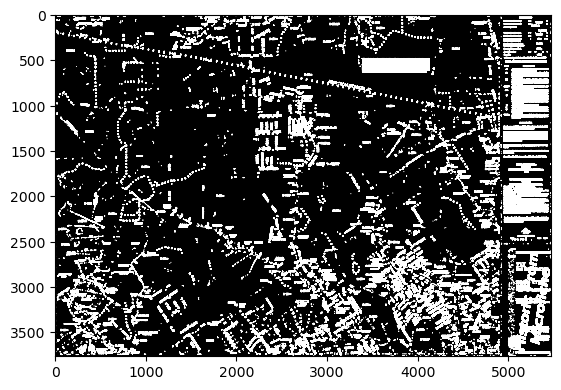

In [34]:
plt.imshow(harris_2 > 0.001, cmap="Greys_r", vmax=0.01)

(array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        2.8632200e+05, 5.0117770e+06, 3.9864949e+08, 9.8536600e+05,
        1.7958400e+05, 4.5838000e+04, 1.2242000e+04, 3.5210000e+03,
        8.8700000e+02, 2.1500000e+02, 2.5000000e+01, 4.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00]),
 array([-0.1  , -0.085, -0.07 , -0.055, -0.04 , -0.025, -0.01 ,  0.005,
         0.02 ,  0.035,  0.05 ,  0.065,  0.08 ,  0.095,  0.11 ,  0.125,
         0.14 ,  0.155,  0.17 ,  0.185,  0.2  ], dtype=float32),
 <BarContainer object of 20 artists>)

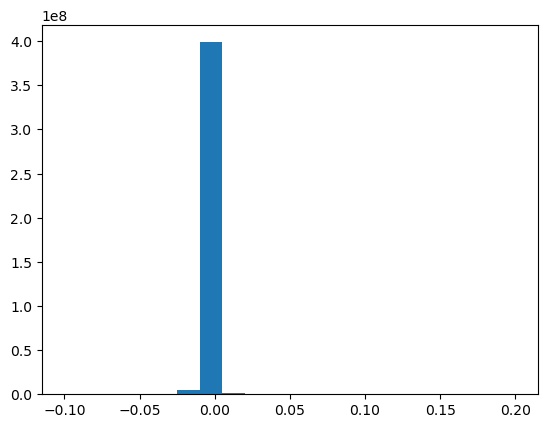

In [18]:
# Set RANSAC parameters
ransac_threshold = 5
ransac_max_trials = 1000

# Convert keypoints to arrays
src_pts = np.float32([ kp1 for m in matches ]).reshape(-1, 1, 2)
dst_pts = np.float32([ kp2 for m in matches ]).reshape(-1, 1, 2)

# Estimate the transformation matrix using RANSAC
model, inliers = ransac((src_pts, dst_pts), ProjectiveTransform, min_samples=4, residual_threshold=ransac_threshold, max_trials=ransac_max_trials)

# Filter out the inliers
matches_filtered = [matches[i] for i in range(len(matches)) if inliers[i]]

# Draw the filtered matches
match_image = cv2.drawMatches(img1_gray, kp1, img2_gray, kp2, matches_filtered, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Show the image
plt.imshow(match_image)
plt.show()

In [77]:
# Set the number of iterations and the threshold for inliers
iterations = 1
inlier_threshold = 10

# Set the minimum number of matches required for the transformation
if len(matches) < 3:
    raise ValueError('At least 3 matches are required for the transformation')
min_matches = 3

In [78]:
# Initialize variables to keep track of the best transformation
best_transform = None
best_inliers = []

# Create the scale-space pyramid for the first image
scale_factor = 2
scaled_images = [img1_trim]
while scaled_images[-1].shape[0] > 300 and scaled_images[-1].shape[1] > 300:
    scaled = cv2.pyrDown(scaled_images[-1])
    print(scaled.shape)
    scaled_images.append(scaled)

(8640, 11725, 3)
(4320, 5863, 3)
(2160, 2932, 3)
(1080, 1466, 3)
(540, 733, 3)
(270, 367, 3)


Fitting Test Image
Iterating
5


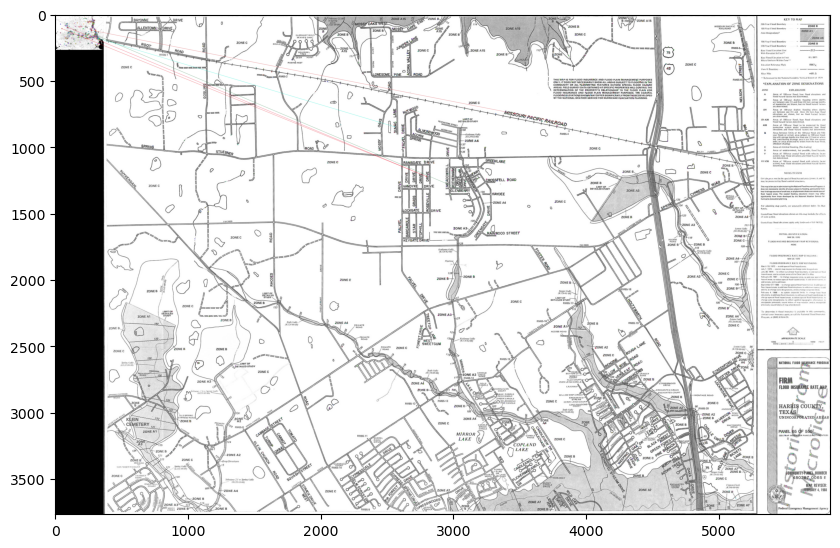

5


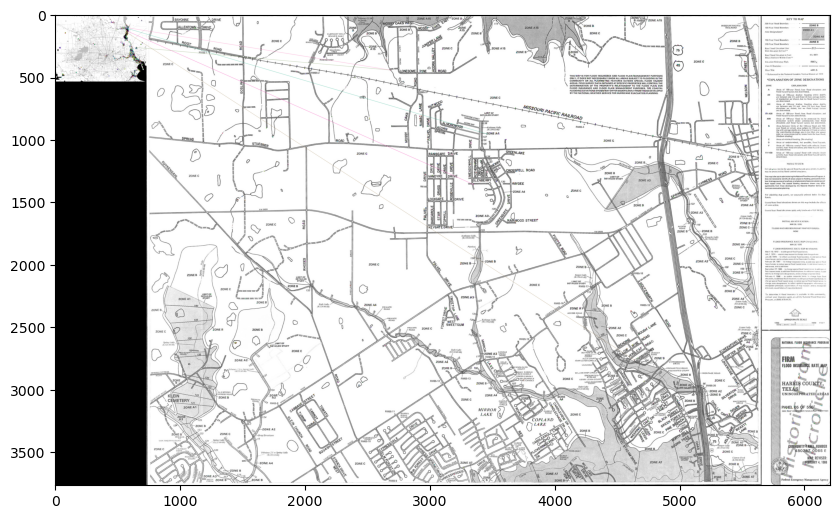

6


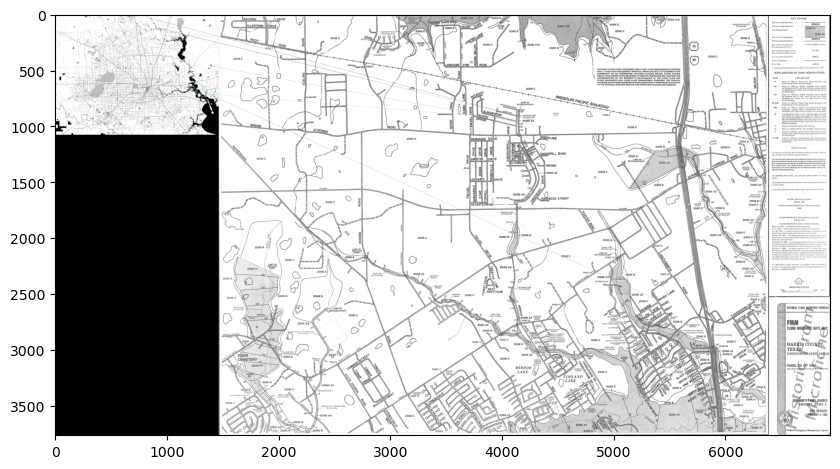

5


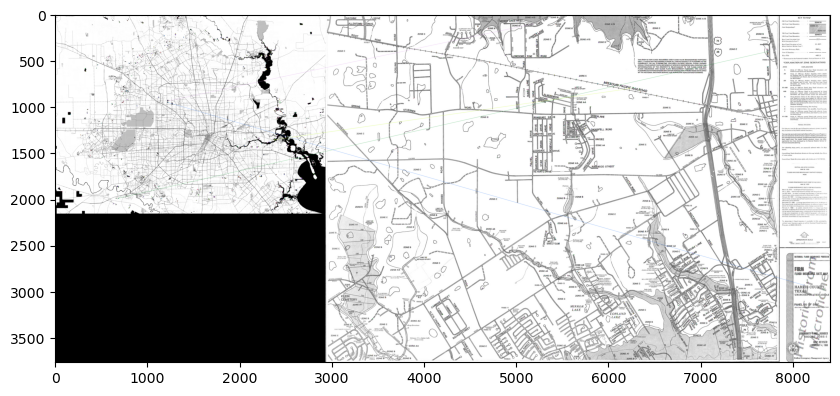

5


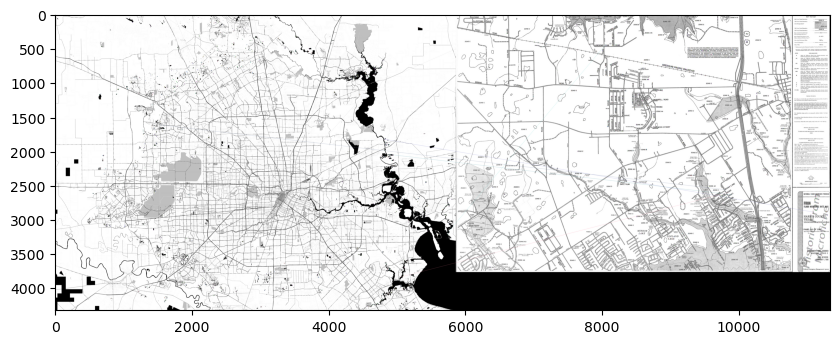

5


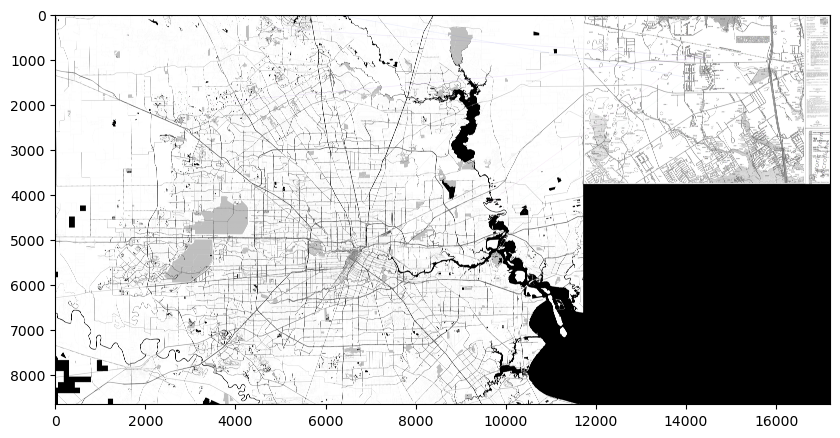

5


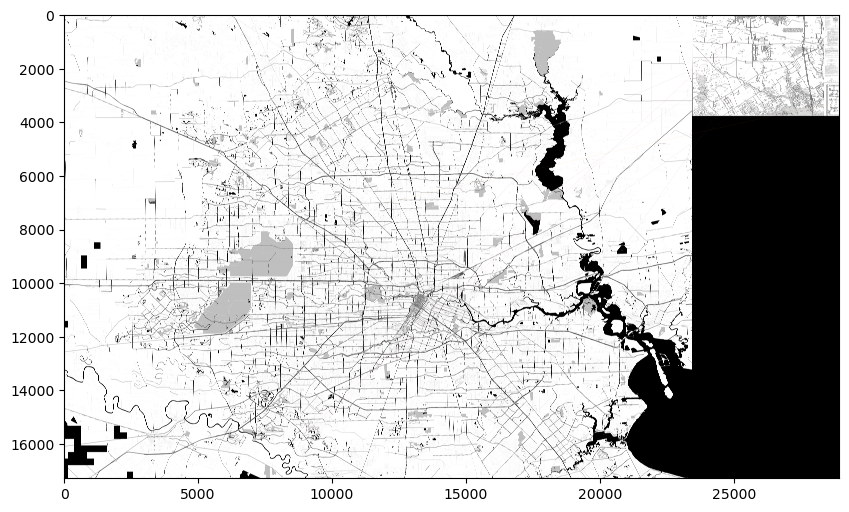

In [82]:
# Set up the parameters for RANSAC algorithm
ransac_threshold = 5
ransac_max_trials = 1000

print("Fitting Test Image")
kp2, des2 = descriptor_extractor.detectAndCompute(img2, None)

print("Iterating")
# Loop through each level of the pyramid in reverse order
for i in range(len(scaled_images)-1, -1, -1):

    # Detect ORB features in the scaled image
    kp1, des1 = descriptor_extractor.detectAndCompute(scaled_images[i], None)

    # Match the ORB features with the original image
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x:x.distance)

    # Get the corresponding keypoints for the matches
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ])
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ])

    # Estimate the transformation matrix using RANSAC
    model, inliers = ransac((src_pts, dst_pts), ProjectiveTransform, min_samples=4, residual_threshold=ransac_threshold, max_trials=ransac_max_trials)

    # Filter out the inliers
    filtered_matches = [match for i, match in enumerate(matches) if inliers[i]]

    # Update the transformation matrix if the current level has a higher resolution
    if i > 0:
        model.params[0:2, 2] *= 2**i
        model.params[2, 2] = 1

    # Update the best transformation matrix if the current level has more inliers
    if np.sum(inliers) > np.sum(best_inliers):
        best_inliers = inliers
        best_transform = model

    # Plot the matches
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    print(len(filtered_matches))
    match_image = cv2.drawMatches(scaled_images[i], kp1, img2, kp2, filtered_matches,None)
    ax.imshow(match_image)
    plt.show()

In [ ]:
MIN_MATCH_COUNT = 3
ransacReprojThreshold=15
# Iterate over each level in the pyramid
for i in range(len(scaled_images)-1, -1, -1):
    img1 = scaled_images[i]
    if i == len(scaled_images) - 1:
        kp1, desc1 = orb.detectAndCompute(img1, None)
        continue

    img2 = scaled_images[i+1]
    kp2, desc2 = orb.detectAndCompute(img2, None)
    
    # match descriptors between img1 and img2
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(desc1, desc2)
    # filter matches using Lowe's ratio test
    good_matches = []
    for m,n in zip(matches[:-1:2], matches[1::2]):
        if m.distance <= 0.75 * n.distance:
            good_matches.append(m)
    print("Checking")
    if len(good_matches) > MIN_MATCH_COUNT:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)
        
        # Estimate the transform matrix using RANSAC algorithm
        transform, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransacReprojThreshold)
        
        
        # Use only inliers to estimate the transform matrix again
        good_matches = [good_matches[i] for i in range(len(good_matches)) if mask[i]]
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)
        
        transform, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransacReprojThreshold)

        # Scale the transformation matrix for the next image size
        h1, w1 = img1.shape[:2]
        h2, w2 = img2.shape[:2]
        transform[0,2] *= w1/w2
        transform[1,2] *= h1/h2

        # Update the best transformation matrix
        if i == len(scaled_images) - 2:
            best_transform = transform
        else:
            best_transform = np.dot(transform, best_transform)

        # Update the keypoints and descriptors for the next iteration
        kp1, desc1 = kp2, desc2
    else:
        print("Not enough matches found - {}/{}".format(len(good_matches), MIN_MATCH_COUNT))
        break

In [47]:
# Warp the reference image to align with the test image
warped_image = cv2.warpPerspective(img2, np.linalg.inv(best_transform), (img2.shape[1], img2.shape[0]))

# Show the images side-by-side
merged_image = np.hstack([warped_image, img2])

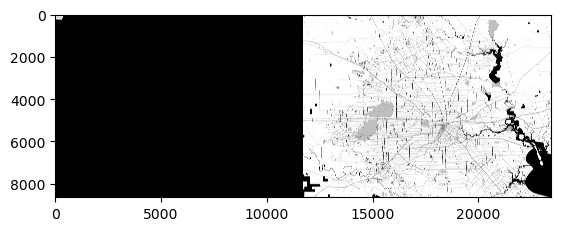

In [48]:
plt.imshow(merged_image)